In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")
import sklearn
import tensorflow as tf
import os
import shutil
import nibabel as nib
import cv2
from PIL import Image
from tensorflow.keras import layers, models, regularizers, Model, callbacks, applications
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import joblib

# Organización y exploración de datos

In [2]:
# Define paths

train_path = './data/Prostate_Dataset/train'
train_notsignificant_path = train_path + '/notsignificant'
train_significant_path = train_path + '/significant'

test_path = './data/Prostate_Dataset/test'
test_notsignificant_path = test_path + '/notsignificant'
test_significant_path = test_path + '/significant'

print(train_path + '\n' + train_notsignificant_path + '\n' + train_significant_path)
print(test_path + '\n' + test_notsignificant_path + '\n' + test_significant_path)

./data/Prostate_Dataset/train
./data/Prostate_Dataset/train/notsignificant
./data/Prostate_Dataset/train/significant
./data/Prostate_Dataset/test
./data/Prostate_Dataset/test/notsignificant
./data/Prostate_Dataset/test/significant


In [3]:
#!pip install nibabel opencv-python
#!pip install xgboost
#!pip install lightgbm

In [4]:
# Healthy paths and files creation with different source

# Control variable (True if we don't have the healthy dataset extracted)
healthy = False

# Original dataset path
base_dir = './prostate158_train/prostate158_train/train'

# Destination dataset path
train_healthy_path = './data/Prostate_Dataset/train/healthy'
test_healthy_path = './data/Prostate_Dataset/test/healthy'
os.makedirs(train_healthy_path, exist_ok=True)
os.makedirs(test_healthy_path, exist_ok=True)

# List with all IDs
all_healthy_ids = {
    '037', '040', '042', '044', '049', '054',
    '055', '062', '067', '068', '069', '070', '071', '072', '083', '085',
    '091', '093', '094', '095', '097', '098', '102', '108', '115', '116',
    '117', '119', '120', '123', '126', '128', '129', '134', '135', '139',
    '141', '142', '144', '145', '147', '149', '151', '155',
    '022', '023', '047', '056', '061', '084', '087', '127'
}

# test IDs
test_ids = {'022', '023', '047', '056', '061', '084', '087', '127', '024', '026', '028', '034'}

# train IDs
train_ids = all_healthy_ids - test_ids

# Files with similar format to kaggle dataset
wanted_files = {'t2.nii.gz'} #'dwi.nii.gz'

if healthy: # Create dataset just in case we don't have it
    # Healthy dataset creation
    for patient_id in os.listdir(base_dir):
        if patient_id not in all_healthy_ids:
            continue  # Ignore cancer cases

        output_dir = test_healthy_path if patient_id in test_ids else train_healthy_path

        patient_folder = os.path.join(base_dir, patient_id)
        for root, dirs, files in os.walk(patient_folder):
            for fname in files:
                if fname.lower() in wanted_files:
                    src = os.path.join(root, fname)
                    dst = os.path.join(output_dir, f'{patient_id}_{fname}')
                    shutil.copy2(src, dst)

    print("✅ T2 images of healthy patients copied to train/ and test/ according to the specified distribution.")

# Converting .nii.gz files to .jpg

def convert_and_replace_nii_with_jpg(directory):

    count = 0

    for fname in os.listdir(directory):
        if fname.endswith('.nii.gz'):
            filepath = os.path.join(directory, fname)

            try:
                # Load medical image
                img = nib.load(filepath)
                data = img.get_fdata()

                # Take the central slice of the volume (we can take more slices for more precision)
                mid_slice = data.shape[2] // 2
                slice_2d = data[:, :, mid_slice]
                slice_2d = np.nan_to_num(slice_2d)

                # Normalize to be visible in grayscale
                norm_slice = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX)
                norm_slice = norm_slice.astype(np.uint8)

                # Save as JPG
                jpg_name = fname.replace('.nii.gz', '.jpg')
                cv2.imwrite(os.path.join(directory, jpg_name), norm_slice)

                # Remove original file
                os.remove(filepath)
                count += 1

            except Exception as e:
                print(f"⚠️ Error in {fname}: {e}")

    if count > 0:
        print(f"✅ {count} .nii.gz files converted to .jpg and deleted in '{directory}'")

# Files conversion
convert_and_replace_nii_with_jpg(train_healthy_path)
convert_and_replace_nii_with_jpg(test_healthy_path)


In [5]:
# Delete dwi files

def eliminar_dwi_en_carpeta(folder):
    count = 0
    for fname in os.listdir(folder):
        if 'dwi' in fname.lower() and fname.endswith('.jpg'):
            filepath = os.path.join(folder, fname)
            try:
                os.remove(filepath)
                count += 1
            except Exception as e:
                print(f"⚠️ Could not delete {fname}: {e}")
    print(f"🗑️ {count} DWI images removed in: {folder}")


eliminar_dwi_en_carpeta(train_healthy_path)
eliminar_dwi_en_carpeta(test_healthy_path)


🗑️ 0 DWI images removed in: ./data/Prostate_Dataset/train/healthy
🗑️ 0 DWI images removed in: ./data/Prostate_Dataset/test/healthy


In [6]:
# Data augmentation with image rotations to avoid wrong classification depending on source format
def augment_with_rotations_if_needed(train_path):
    classes = os.listdir(train_path)

    for class_name in classes:
        class_dir = os.path.join(train_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Search for existing rotated images
        rotated_imgs = [f for f in os.listdir(class_dir) if 'rotated' in f.lower() and f.lower().endswith('.jpg')]

        if rotated_imgs:
            print(f"[{class_name}] Have been found {len(rotated_imgs)} rotated images. Data augmentation is not performed.")
            continue

        print(f"[{class_name}] Performing image rotations...")

        for file in os.listdir(class_dir):
            if file.lower().endswith('.jpg') and 'rotated' not in file:
                img_path = os.path.join(class_dir, file)
                try:
                    img = Image.open(img_path)

                    for angle in [90, 180, 270]:
                        rotated_img = img.rotate(angle)
                        new_filename = file.replace('.jpg', f'_rotated{angle}.jpg')
                        rotated_img.save(os.path.join(class_dir, new_filename))

                except Exception as e:
                    print(f"Image error with {file}: {e}")

        print(f"[{class_name}] Rotations completed.")

augment_with_rotations_if_needed(train_path)


[healthy] Have been found 132 rotated images. Data augmentation is not performed.
[notsignificant] Have been found 1608 rotated images. Data augmentation is not performed.
[significant] Have been found 1608 rotated images. Data augmentation is not performed.


Found 4464 files belonging to 3 classes.
Found 468 files belonging to 3 classes.
['healthy', 'notsignificant', 'significant']
Image 1 shape: (256, 256, 3)
Image 1 channels: 3
Image 2 shape: (256, 256, 3)
Image 2 channels: 3
Image 3 shape: (256, 256, 3)
Image 3 channels: 3
Image 4 shape: (256, 256, 3)
Image 4 channels: 3
Image 5 shape: (256, 256, 3)
Image 5 channels: 3
Image 6 shape: (256, 256, 3)
Image 6 channels: 3
Image 7 shape: (256, 256, 3)
Image 7 channels: 3
Image 8 shape: (256, 256, 3)
Image 8 channels: 3
Image 9 shape: (256, 256, 3)
Image 9 channels: 3


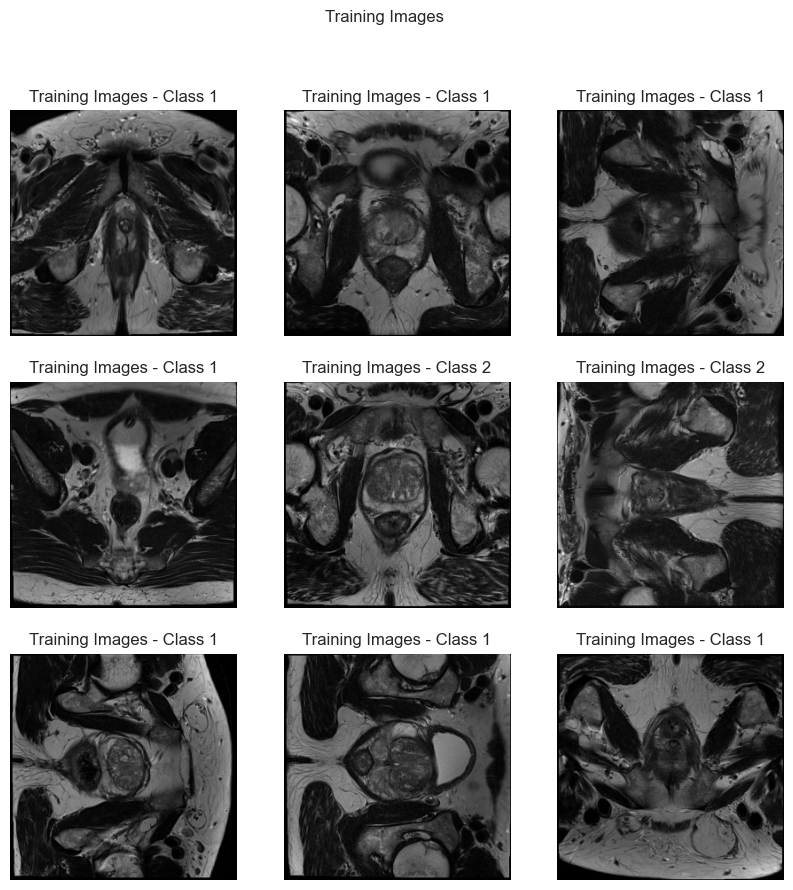

Image 1 shape: (256, 256, 3)
Image 1 channels: 3
Image 2 shape: (256, 256, 3)
Image 2 channels: 3
Image 3 shape: (256, 256, 3)
Image 3 channels: 3
Image 4 shape: (256, 256, 3)
Image 4 channels: 3
Image 5 shape: (256, 256, 3)
Image 5 channels: 3
Image 6 shape: (256, 256, 3)
Image 6 channels: 3
Image 7 shape: (256, 256, 3)
Image 7 channels: 3
Image 8 shape: (256, 256, 3)
Image 8 channels: 3
Image 9 shape: (256, 256, 3)
Image 9 channels: 3


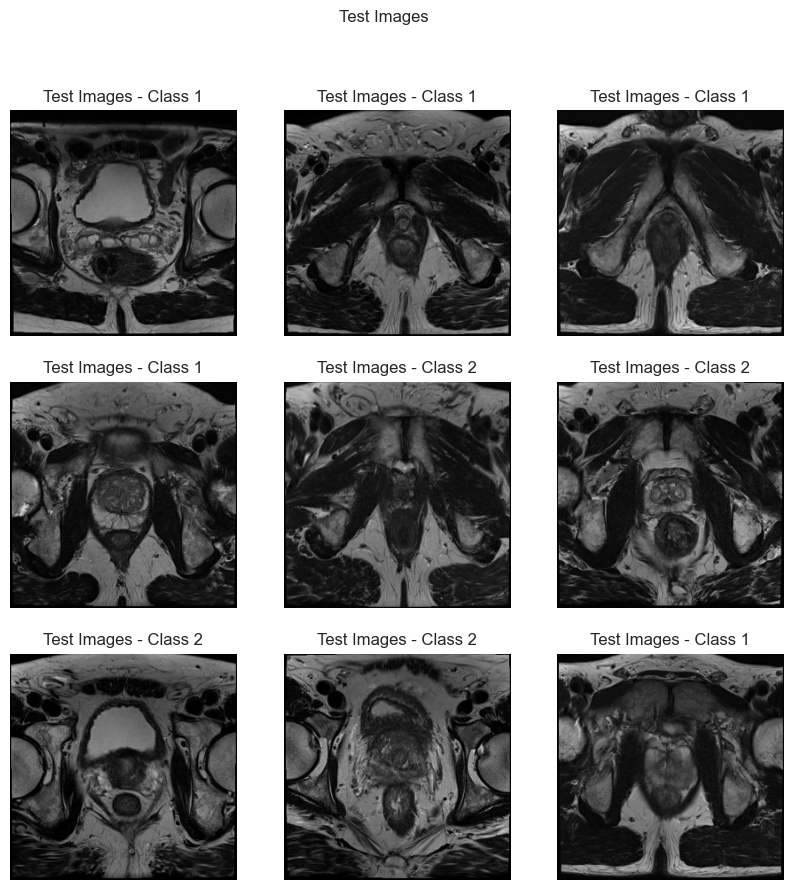

In [7]:
# Define image size and batch size
image_size = (256, 256)
batch_size = 32

# Load dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=image_size,  # Resize images to 256x256
    batch_size=batch_size,  # Load images in batches of 32
    label_mode='int'  # Labels are returned as integers
)

# Load the validation dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=image_size,  # Resize images to 256x256
    batch_size=batch_size,  # Load images in batches of 32
    label_mode='int'  # Labels are returned as integers
)

# Function to display images from a dataset batch
def display_images(dataset, title, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(num_images):
            image = images[i].numpy().astype("uint8")  # Convert tensor to uint8 numpy array
            print(f"Image {i+1} shape: {image.shape}")  # Print shape
            if image.ndim == 3:
                print(f"Image {i+1} channels: {image.shape[-1]}")  # Print number of channels
            
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image)  # Display image
            plt.title(f"{title} - Class {labels[i].numpy()}")  # Display class label
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Display class names (0 -> healthy, 1 -> notsignificant, 2 -> significant)
class_names = test_dataset.class_names
print(class_names)

# Display images from the train and validation datasets
display_images(train_dataset, title="Training Images")
display_images(test_dataset, title="Test Images")

# Extracción embeddings con VGG16 y evaluación en RF/SVM

In [9]:
# Load VGG16 with ImageNet weights and correct input shape (224, 224, 3) 
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Create a model that outputs the penultimate layer (Dense before softmax) 
embedding_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
# For VGG16, this gives you embeddings of size 4096

# Define preprocessing functions for VGG16
def preprocess_vgg_test(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)  # Applies VGG16 normalization
    return image, label

def preprocess_vgg_train(image, label):
    # image = tf.image.central_crop(image, central_fraction=0.8)
    image = tf.image.resize(image, (224, 224))
    # image = tf.image.adjust_contrast(image, 1.3)
    # image = tf.image.adjust_brightness(image, 0.05)
    # noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
    # image = image + noise
    # image = tf.clip_by_value(image, 0.0, 1.0)
    image = preprocess_input(image)
    return image, label

# Load and preprocess your datasets 
train_dataset_vgg = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='int'
).map(preprocess_vgg_train).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset_vgg = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='int'
).map(preprocess_vgg_test).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Function to extract embeddings from the dataset using the embedding model 
def extract_embeddings(model, dataset):
    embeddings = []
    labels = []
    for images, lbls in dataset:
        embs = model(images, training=False)
        embeddings.append(embs.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

# Extract embeddings for train and test
X_train_vgg, y_train_vgg = extract_embeddings(embedding_model, train_dataset_vgg)
X_test_vgg, y_test_vgg = extract_embeddings(embedding_model, test_dataset_vgg)

# Standardize the embeddings
scaler = StandardScaler()
X_train_vgg_scaled = scaler.fit_transform(X_train_vgg)
X_test_vgg_scaled = scaler.transform(X_test_vgg)

# Train and evaluate a Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_vgg_scaled, y_train_vgg)
y_pred_rf = rf.predict(X_test_vgg_scaled)
print("\nRandom Forest Results:")
print(classification_report(y_test_vgg, y_pred_rf))
print("Confusion matrix RF:")
print(confusion_matrix(y_test_vgg, y_pred_rf))

# Train and evaluate a SVM classifier 
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_vgg_scaled, y_train_vgg)
y_pred_svm = svm.predict(X_test_vgg_scaled)
print("\nSVM Results:")
print(classification_report(y_test_vgg, y_pred_svm))
print("Confusion matrix SVM:")
print(confusion_matrix(y_test_vgg, y_pred_svm))




Found 4464 files belonging to 3 classes.
Found 468 files belonging to 3 classes.

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.59      0.65      0.62       228
           2       0.61      0.55      0.58       228

    accuracy                           0.61       468
   macro avg       0.73      0.73      0.73       468
weighted avg       0.61      0.61      0.61       468

Confusion matrix RF:
[[ 12   0   0]
 [  0 148  80]
 [  0 102 126]]

SVM Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.59      0.65      0.62       228
           2       0.61      0.54      0.58       228

    accuracy                           0.61       468
   macro avg       0.73      0.73      0.73       468
weighted avg       0.61      0.61      0.61       468

Confusion matrix SVM:
[[ 12   0   0]
 [  0 149  79

# Evaluación aplicando PCA para reducción dimensionalidad

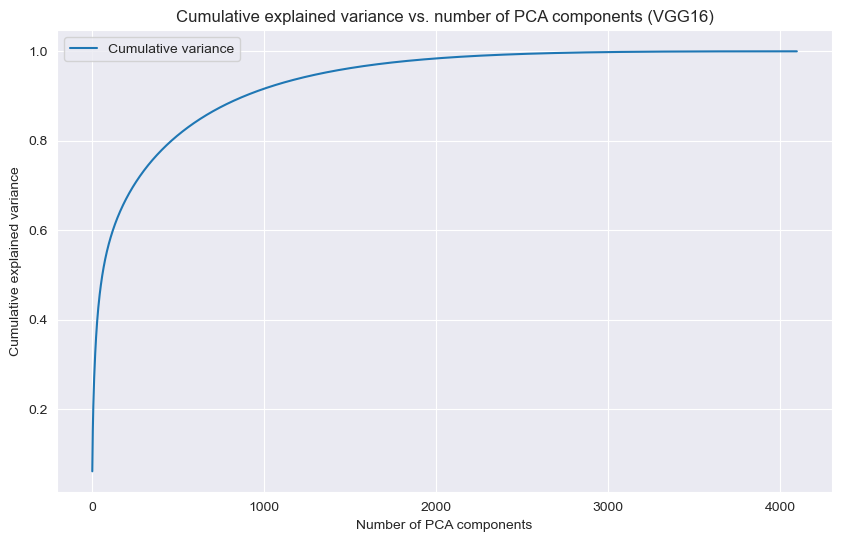

Cumulative variance with 8 components: 22.22%
Cumulative variance with 50 components: 47.53%
Cumulative variance with 100 components: 57.40%
Cumulative variance with 250 components: 70.51%
Cumulative variance with 500 components: 81.31%
Cumulative variance with 1000 components: 91.65%
Cumulative variance with 2048 components: 98.55%
Cumulative variance with 4096 components: 100.00%
Results with PCA (n_components=8):

Random Forest accuracy: 54.70%
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.54      0.45      0.49       228
           2       0.53      0.63      0.58       228

    accuracy                           0.55       468
   macro avg       0.69      0.66      0.67       468
weighted avg       0.55      0.55      0.54       468

Confusion Matrix RF:
[[ 11   1   0]
 [  0 102 126]
 [  0  85 143]]

SVM accuracy: 53.63%
              precision    recall  f1-score   support

           0       1.00


SVM accuracy: 61.11%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.59      0.65      0.62       228
           2       0.61      0.55      0.58       228

    accuracy                           0.61       468
   macro avg       0.73      0.73      0.73       468
weighted avg       0.61      0.61      0.61       468

Confusion Matrix SVM:
[[ 12   0   0]
 [  0 149  79]
 [  0 103 125]]
   n_components    acc_rf   acc_svm
0             8  0.547009  0.536325
1            50  0.568376  0.576923
2           100  0.572650  0.587607
3           250  0.542735  0.621795
4           500  0.574786  0.602564
5          1000  0.596154  0.613248
6          2048  0.542735  0.611111
7          4096  0.495726  0.611111


In [10]:
# Max components for PCA (embedding size is 4096 for VGG16)
n_components_max = 4096

# Fit PCA on train embeddings
pca_full = PCA(n_components=n_components_max, random_state=42)
pca_full.fit(X_train_vgg_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components_max + 1), cumulative_variance, label='Cumulative variance')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance vs. number of PCA components (VGG16)')
plt.grid(True)
plt.legend()
plt.show()

# Print cumulative variance for selected values
for n in [8, 50, 100, 250, 500, 1000, 2048, 4096]:
    print(f"Cumulative variance with {n} components: {cumulative_variance[n-1]:.2%}")

# Try these numbers of components
n_components_list = [8, 50, 100, 250, 500, 1000, 2048, 4096]

results = []

for n_components in n_components_list:
    print("="*50)
    print(f"Results with PCA (n_components={n_components}):")
    
    # Fit PCA and transform
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_vgg_scaled)
    X_test_pca = pca.transform(X_test_vgg_scaled)

    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_pca, y_train_vgg)
    y_pred_rf = rf.predict(X_test_pca)
    acc_rf = rf.score(X_test_pca, y_test_vgg)
    print(f"\nRandom Forest accuracy: {acc_rf:.2%}")
    print(classification_report(y_test_vgg, y_pred_rf, digits=2))
    print("Confusion Matrix RF:")
    print(confusion_matrix(y_test_vgg, y_pred_rf))

    # SVM
    svm = SVC(probability=True, random_state=42)
    svm.fit(X_train_pca, y_train_vgg)
    y_pred_svm = svm.predict(X_test_pca)
    acc_svm = svm.score(X_test_pca, y_test_vgg)
    print(f"\nSVM accuracy: {acc_svm:.2%}")
    print(classification_report(y_test_vgg, y_pred_svm, digits=2))
    print("Confusion Matrix SVM:")
    print(confusion_matrix(y_test_vgg, y_pred_svm))

    results.append({
        'n_components': n_components,
        'acc_rf': acc_rf,
        'acc_svm': acc_svm
    })
    print("="*50)

# Tabular summary
df_results = pd.DataFrame(results)
print(df_results)


## Conclusiones PCA en embeddings para reduccion dimensionalidad (codigo en anteriores versiones)

Aunque solo aparezca el código para VGG16 (el utilizado finalmente), para el resto de redes es análogo.

### Resnet50

| Nº Componentes | Varianza acumulada | RF Accuracy | SVM Accuracy |
| :------------: | :----------------: | :---------: | :----------: |
|        8       |        28.6%       |     0.52    |     0.54     |
|       50       |        56.7%       |     0.53    |     0.57     |
|       100      |        67.6%       |     0.49    |     0.56     |
|       250      |        80.7%       |     0.52    |     0.57     |
|       500      |        89.7%       |     0.50    |     0.57     |
|      1000      |        96.8%       |     0.54    |     0.57     |
|  2048 (todas)  |        100%        |     0.43    |     0.58     |

Se ha aplicado reducción de dimensionalidad con PCA sobre los embeddings de ResNet50, evaluando el rendimiento para distintos números de componentes. Los resultados muestran que utilizar 50 componentes (en SVM) permite simplificar el modelo significativamente, manteniendo el accuracy prácticamente igual al máximo observado (≈0.57) y explicando el 56% de la varianza de los datos originales. Esta elección favorece una mejor generalización y ayuda a reducir el sobreajuste, sin pérdida apreciable de accuracy

### VGG16

| Nº Componentes | Varianza acumulada | RF Accuracy | SVM Accuracy |
| :------------: | :----------------: | :---------: | :----------: |
|        8       |        22.2%       |     0.54    |     0.54     |
|       50       |        47.5%       |     0.56    |     0.58     |
|       100      |        57.4%       |     0.57    |     0.59     |
|       250      |        70.5%       |     0.58    |     0.62     |
|       500      |        81.3%       |     0.55    |     0.60     |
|      1000      |        91.7%       |     0.55    |     0.61     |
|      2048      |        98.6%       |     0.56    |     0.61     |
|      4096      |       100.0%       |     0.49    |     0.61     |

Se ha aplicado reducción de dimensionalidad con PCA sobre los embeddings de VGG16, evaluando el rendimiento con distintos números de componentes. Los resultados muestran que utilizar 250 componentes en SVM permite alcanzar el accuracy máximo observado (≈0.62), explicando además un 70% de la varianza de los datos originales. Este compromiso permite mantener un modelo más manejable y menos propenso al sobreajuste, mejorando la generalización y sin pérdida de capacidad predictiva

### EfficientNetB0

| Nº Componentes | Varianza acumulada | RF Accuracy | SVM Accuracy |
| :------------: | :----------------: | :---------: | :----------: |
|        8       |        31.8%       |     0.51    |     0.53     |
|       50       |        60.5%       |     0.60    |     0.58     |
|       100      |        71.5%       |     0.63    |     0.61     |
|       250      |        85.1%       |     0.56    |     0.61     |
|       500      |        93.9%       |     0.57    |     0.61     |
|      1000      |        99.3%       |     0.53    |     0.62     |
|      1280      |       100.0%       |     0.53    |     0.62     |

Se ha aplicado reducción de dimensionalidad con PCA sobre los embeddings de EfficientNetB0, evaluando el rendimiento de SVM y Random Forest con distintos números de componentes. Los resultados muestran que el mejor valor puntual de accuracy se obtiene con Random Forest utilizando 100 componentes (≈0.63), explicando un 71% de la varianza. Sin embargo, SVM consigue un rendimiento muy similar con la misma cantidad de componentes (≈0.61) y además mantiene una mayor estabilidad y menor riesgo de sobreajuste al aumentar el número de componentes. Por tanto, aunque RF logra el máximo puntual, SVM se considera la opción preferente por su equilibrio entre simplicidad, estabilidad y capacidad de generalización.

### DenseNet121

| Nº Componentes | Varianza acumulada | RF Accuracy | SVM Accuracy |
| :------------: | :----------------: | :---------: | :----------: |
|        8       |        35.0%       |     0.47    |     0.54     |
|       50       |        65.8%       |     0.53    |     0.56     |
|       100      |        76.7%       |     0.54    |     0.58     |
|       250      |        89.0%       |     0.51    |     0.58     |
|       500      |        96.3%       |     0.51    |     0.59     |
|      1024      |       100.0%       |     0.48    |     0.59     |

Se ha aplicado reducción de dimensionalidad con PCA sobre los embeddings de DenseNet121, evaluando el rendimiento para distintos números de componentes. Los resultados muestran que utilizar entre 100 y 500 componentes (en SVM) permite alcanzar el accuracy máximo observado (~0.59), explicando entre el 77% y el 96% de la varianza de los datos originales. Con este rango de componentes se mantiene un modelo manejable y con buena capacidad de generalización, sin que el aumento de la complejidad aporte mejoras significativas adicionales en accuracy. Por tanto, SVM con 100–500 componentes ofrece el mejor equilibrio entre simplicidad, generalización y rendimiento predictivo.

### Xception

| Nº Componentes | Varianza acumulada | RF Accuracy | SVM Accuracy |
| :------------: | :----------------: | :---------: | :----------: |
|        8       |        27.9%       |     0.54    |     0.52     |
|       50       |        56.8%       |     0.57    |     0.58     |
|       100      |        67.7%       |     0.55    |     0.55     |
|       250      |        80.7%       |     0.51    |     0.55     |
|       500      |        89.5%       |     0.50    |     0.55     |
|      1000      |        96.6%       |     0.50    |     0.54     |
|  2048 (todas)  |        100%        |     0.45    |     0.54     |

Se ha aplicado reducción de dimensionalidad con PCA sobre los embeddings de Xception, evaluando el rendimiento para distintos números de componentes. Los resultados muestran que utilizar 50 componentes (en SVM) permite simplificar el modelo significativamente, manteniendo el accuracy prácticamente igual al máximo observado (≈0.58) y explicando el 57% de la varianza de los datos originales. Esta elección favorece una mejor generalización y ayuda a reducir el sobreajuste, sin pérdida apreciable de capacidad predictiva.

# Comparativa modelos RF, SVM, XGBoost, LightGBM, KNN, Naive Bayes

Una vez decidido que la mejor opción es utilizar 250 componentes en SVM usando VGG16 como extractor de embeddings (aunque hemos obtenido resultados similares) pasamos a la evaluación de más modelos distintos.

In [11]:
# List of PCA components to test
n_components_list = [8, 50, 250, 500, 1000, 2048, 4096]  # Incluye 4096 para VGG16

# DataFrame to store results
results_summary = []

for n_components in n_components_list:
    print("="*60)
    print(f"Results with PCA (n_components={n_components}):")
    # Fit PCA and transform datasets
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_vgg_scaled)
    X_test_pca = pca.transform(X_test_vgg_scaled)
    
    models = {
        "RandomForest": RandomForestClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        "LightGBM": LGBMClassifier(random_state=42),
        "KNN": KNeighborsClassifier(),
        "NaiveBayes": GaussianNB()
    }
    
    for model_name, model in models.items():
        model.fit(X_train_pca, y_train_vgg)
        y_pred_train = model.predict(X_train_pca)
        y_pred_test = model.predict(X_test_pca)
        
        acc_train = accuracy_score(y_train_vgg, y_pred_train)
        acc_test = accuracy_score(y_test_vgg, y_pred_test)
        
        print(f"\nModel: {model_name} | Train Accuracy: {acc_train:.3f} | Test Accuracy: {acc_test:.3f}")
        print("Classification Report (Test):")
        print(classification_report(y_test_vgg, y_pred_test, digits=2))
        print("Confusion Matrix (Test):")
        print(confusion_matrix(y_test_vgg, y_pred_test))
        
        # Save results for later comparison
        results_summary.append({
            "Model": model_name,
            "n_components": n_components,
            "Train_Accuracy": acc_train,
            "Test_Accuracy": acc_test
        })

# Convert results to DataFrame for overview
df_results_summary = pd.DataFrame(results_summary)
print("\n=== Summary Table ===")
print(df_results_summary.pivot(index='n_components', columns='Model', values='Test_Accuracy'))


Results with PCA (n_components=8):

Model: RandomForest | Train Accuracy: 1.000 | Test Accuracy: 0.547
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.54      0.45      0.49       228
           2       0.53      0.63      0.58       228

    accuracy                           0.55       468
   macro avg       0.69      0.66      0.67       468
weighted avg       0.55      0.55      0.54       468

Confusion Matrix (Test):
[[ 11   1   0]
 [  0 102 126]
 [  0  85 143]]

Model: SVM | Train Accuracy: 0.753 | Test Accuracy: 0.536
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.53      0.44      0.48       228
           2       0.52      0.61      0.56       228

    accuracy                           0.54       468
   macro avg       0.68      0.66      0.67       468



Model: SVM | Train Accuracy: 0.977 | Test Accuracy: 0.622
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.60      0.66      0.63       228
           2       0.62      0.56      0.59       228

    accuracy                           0.62       468
   macro avg       0.74      0.74      0.74       468
weighted avg       0.62      0.62      0.62       468

Confusion Matrix (Test):
[[ 12   0   0]
 [  0 151  77]
 [  0 100 128]]

Model: XGBoost | Train Accuracy: 1.000 | Test Accuracy: 0.553
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.54      0.60      0.57       228
           2       0.55      0.49      0.52       228

    accuracy                           0.55       468
   macro avg       0.69      0.69      0.69       468
weighted avg       0.55      0.55      0


Model: XGBoost | Train Accuracy: 1.000 | Test Accuracy: 0.575
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.56      0.60      0.58       228
           2       0.57      0.53      0.55       228

    accuracy                           0.57       468
   macro avg       0.71      0.71      0.71       468
weighted avg       0.58      0.57      0.57       468

Confusion Matrix (Test):
[[ 12   0   0]
 [  0 137  91]
 [  0 108 120]]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255000
[LightGBM] [Info] Number of data points in the train set: 4464, number of used features: 1000
[LightGBM] [Info] Start training from score -3.233317
[LightGBM] [Info] Start training from score -0.733372
[LightGBM] [Info] Start training from score -0.733372
[

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1044480
[LightGBM] [Info] Number of data points in the train set: 4464, number of used features: 4096
[LightGBM] [Info] Start training from score -3.233317
[LightGBM] [Info] Start training from score -0.733372
[LightGBM] [Info] Start training from score -0.733372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Model: LightGBM | Train Accuracy: 1.000 | Test Accuracy: 0.573
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.55      0.62      0.59       228
           2       0.57      0.50      0.53       228

    accuracy                           0.57       468
   macro avg       0.71      0.71      0.71       468
weighted avg       0.57      0.57      0.57       

## Conclusiones comparativa modelos con distintas componentes (usando VGG16)

El modelo SVM con 250 componentes PCA proporciona el mejor equilibrio entre simplicidad, rendimiento y generalización, alcanzando el máximo accuracy en test (~0.62) sin recurrir a una dimensionalidad excesiva. Con este número de componentes se explica el 70% de la varianza y se evita el sobreajuste extremo observado al aumentar el número de componentes. A partir de este punto, incrementar la complejidad apenas mejora la capacidad predictiva y puede perjudicar la generalización. Otros modelos como KNN o LightGBM muestran resultados similares pero ligeramente inferiores, consolidando a SVM como la mejor opción con embeddings de VGG16

Para 250 componentes:
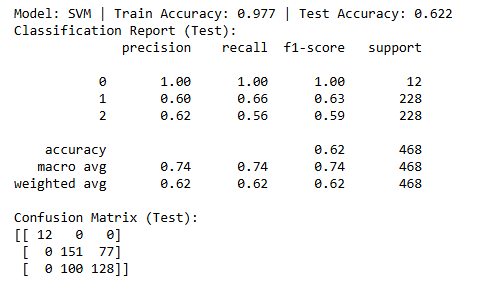

El rendimiento de SVM también se mantiene elevado y estable en el rango de 100 a 1000 componentes, lo que aporta flexibilidad según la preferencia por simplicidad o por varianza explicada

## VGG16 con SVM (n=250) es el que obtiene mejores resultados

# GridSearch + K-Fold Cross Validation

Se ha utilizado GridSearch junto con validación cruzada K-fold para seleccionar los mejores hiperparámetros del modelo SVM. Esta estrategia permite mejorar el rendimiento general del modelo y asegurar que los resultados no dependan de una única partición de los datos, mejorando así la capacidad de generalización.

In [12]:
# Reduce the PCA to 250 components (the best case for VGG16)
n_components = 250
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_vgg_scaled)
X_test_pca = pca.transform(X_test_vgg_scaled)

# Grid of parameters for tuning
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'linear'],
}

# Grid search with 3-fold CV
grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_pca, y_train_vgg)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Evaluate on test set
y_pred = grid.best_estimator_.predict(X_test_pca)
print("Test accuracy:", accuracy_score(y_test_vgg, y_pred))
print("Classification report:\n", classification_report(y_test_vgg, y_pred))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.962589605734767
Test accuracy: 0.5790598290598291
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.56      0.64      0.60       228
           2       0.58      0.49      0.53       228

    accuracy                           0.58       468
   macro avg       0.71      0.71      0.71       468
weighted avg       0.58      0.58      0.58       468



Se realizó una búsqueda de hiperparámetros usando GridSearchCV con validación cruzada (k-fold, k=3), identificando la mejor combinación de parámetros (C, gamma, kernel) para el modelo SVM. Esta combinación optimiza el rendimiento en validación y posteriormente se evalúa en el conjunto de test, reportando las métricas finales.

Tras realizar ajuste de hiperparámetros mediante GridSearch con validación cruzada, el modelo SVM ajustado muestra una ligera reducción en la accuracy tanto en entrenamiento (de 0.977 a 0.962) como en test (de 0.622 a 0.579) respecto al modelo base. Sin embargo, esta pequeña pérdida de rendimiento en test es asumible y justificable, ya que el modelo optimizado mediante validación cruzada resulta más robusto y generalizable, minimizando el riesgo de sobreajuste

In [15]:
# Save the fitted SVM (the best from the grid search)
joblib.dump(grid.best_estimator_, "modelo_svm_vgg16_pca250.joblib")

# Save the PCA (essential to transform new data just like the train)
joblib.dump(pca, "pca_vgg16_250c.joblib")

# Save the scaler
joblib.dump(scaler, "scaler_vgg16.joblib")

['scaler_vgg16.joblib']

## Flujo completo para prueba conjunto de test o nuevos datos

In [15]:
# Load base model and create embedding extractor
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
embedding_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Preprocess images (example here for testing, but valid for new data)
def preprocess_vgg(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    return image, label

test_dataset_vgg = tf.keras.preprocessing.image_dataset_from_directory(
    test_path, 
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='int'
).map(preprocess_vgg).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Extract embeddings
def extract_embeddings(model, dataset):
    embeddings = []
    labels = []
    for images, lbls in dataset:
        embs = model(images, training=False)
        embeddings.append(embs.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

X_test_vgg, y_test_vgg = extract_embeddings(embedding_model, test_dataset_vgg)

# Load saved scaler, PCA and SVM model
scaler = joblib.load("scaler_vgg16.joblib")
pca = joblib.load("pca_vgg16_250c.joblib")
modelo_svm = joblib.load("modelo_svm_vgg16_pca250.joblib")

# Standardize and transform
X_test_vgg_scaled = scaler.transform(X_test_vgg)
X_test_pca = pca.transform(X_test_vgg_scaled)

# Get probabilities
probs_test = modelo_svm.predict_proba(X_test_pca)

# Visualization of class probabilities for selected examples (test)

# Maps index to class name
class_names = ["Healthy", "Not Significant", "Significant"]

# Calculate the predicted class
pred_class_indices = np.argmax(probs_test, axis=1)
true_class_indices = y_test_vgg

# Build the DataFrame
df_pred = pd.DataFrame({
    "Patient_ID": np.arange(len(y_test_vgg)),
    "True_Class": [class_names[i] for i in true_class_indices],
    "Predicted_Class": [class_names[i] for i in pred_class_indices],
    "Prob_Healthy": probs_test[:, 0],
    "Prob_NotSignif": probs_test[:, 1],
    "Prob_Significant": probs_test[:, 2]
})

# Which rows were hits and which were misses?
df_pred["Correct"] = df_pred["True_Class"] == df_pred["Predicted_Class"]

# Select, for each class, half of the correct examples and half of the incorrect ones
n_ejemplos = 4 
n_aciertos = n_ejemplos // 2
n_fallos = n_ejemplos - n_aciertos

df_muestra = pd.DataFrame()
for clase in class_names:
    aciertos = df_pred[(df_pred["True_Class"] == clase) & (df_pred["Correct"])].head(n_aciertos)
    fallos = df_pred[(df_pred["True_Class"] == clase) & (~df_pred["Correct"])].head(n_fallos)
    df_muestra = pd.concat([df_muestra, aciertos, fallos])

# Reset index to see clean table
df_muestra = df_muestra.reset_index(drop=True)

print("\n--- Ejemplos balanceados de aciertos y errores por clase ---")
print(df_muestra[["Patient_ID", "True_Class", "Predicted_Class", "Prob_Healthy", "Prob_NotSignif", "Prob_Significant"]].to_string(index=False))




Found 468 files belonging to 3 classes.

--- Ejemplos balanceados de aciertos y errores por clase ---
 Patient_ID      True_Class Predicted_Class  Prob_Healthy  Prob_NotSignif  Prob_Significant
         51         Healthy         Healthy      0.999452        0.000149          0.000399
         86         Healthy         Healthy      0.999453        0.000291          0.000255
          1 Not Significant Not Significant      0.000003        0.782902          0.217095
          5 Not Significant Not Significant      0.000033        0.993664          0.006303
          2 Not Significant     Significant      0.000054        0.208905          0.791041
          6 Not Significant     Significant      0.000003        0.001982          0.998015
         10     Significant     Significant      0.001494        0.030551          0.967954
         12     Significant     Significant      0.000241        0.006851          0.992909
          0     Significant Not Significant      0.000081        0.745

### Apunte resultados

El modelo SVM no proporciona probabilidades reales, si no que transforma los scores obtenidos en probabilidades mediante un ajuste adicional posterior. Es por ello que se recomienda servirse de estas probabilidades como una orientacion y no como un reflejo del grado de certeza del modelo.